## 1. Environment Setup and Data Loading

This notebook supports execution on local machines, Google Colab, and Kaggle platforms.

**Author:** Michael Kimani  
**Project:** Poultry Health Classification System

In [2]:
DATASET_NAME = 'poultry-health-dataset' 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

Python: 3.12.12
NumPy: 2.0.2
Pandas: 2.2.2


In [6]:
import os
import sys

def detect_platform():
    if 'COLAB_GPU' in os.environ or 'google.colab' in sys.modules:
        return 'colab'
    elif 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        return 'kaggle'
    else:
        return 'local'

PLATFORM = detect_platform()
print(f"Platform: {PLATFORM.upper()}")

Platform: KAGGLE


In [8]:
if PLATFORM == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_PATH = '/content/drive/MyDrive/Poultry_Dataset/Dataset'
    print("Update DATASET_PATH to match your Google Drive structure")

elif PLATFORM == 'kaggle':
    DATASET_PATH = '/kaggle/input/datasets/michaelkimani00/poultry-dataset/Dataset'

else:
    DATASET_PATH = '/Users/michaelkimani/Downloads/Poultry Birds Poo Imagery Dataset for Health Status Prediction A Case of South-West Nigeria/Dataset'

HEALTHY_PATH = os.path.join(DATASET_PATH, 'Healthy')
UNHEALTHY_PATH = os.path.join(DATASET_PATH, 'Unhealthy')

print(f"Dataset: {DATASET_PATH}")
print(f"Healthy: {HEALTHY_PATH}")
print(f"Unhealthy: {UNHEALTHY_PATH}")


Dataset: /kaggle/input/datasets/michaelkimani00/poultry-dataset/Dataset
Healthy: /kaggle/input/datasets/michaelkimani00/poultry-dataset/Dataset/Healthy
Unhealthy: /kaggle/input/datasets/michaelkimani00/poultry-dataset/Dataset/Unhealthy


In [10]:
def verify_dataset(dataset_path, healthy_path, unhealthy_path):
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path not found: {dataset_path}")
        return False

    if not os.path.exists(healthy_path):
        print(f"Error: Healthy folder not found")
        return False

    if not os.path.exists(unhealthy_path):
        print(f"Error: Unhealthy folder not found")
        return False

    healthy_count = len([f for f in os.listdir(healthy_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    unhealthy_count = len([f for f in os.listdir(unhealthy_path) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    print(f"Healthy images: {healthy_count}")
    print(f"Unhealthy images: {unhealthy_count}")
    print(f"Total: {healthy_count + unhealthy_count}")
    return True

dataset_ok = verify_dataset(DATASET_PATH, HEALTHY_PATH, UNHEALTHY_PATH)

Healthy images: 7991
Unhealthy images: 6627
Total: 14618


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, classification_report, roc_auc_score, roc_curve,
precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import cv2
from PIL import Image

print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

tf.random.set_seed(RANDOM_SEED)

2026-02-17 16:35:10.358025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771346110.555741      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771346110.609374      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771346111.050619      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771346111.050657      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771346111.050660      55 computation_placer.cc:177] computation placer alr

TensorFlow: 2.19.0
GPU Available: True


## 2. Exploratory Data Analysis

In [17]:
def load_image_paths_and_labels(healthy_path, unhealthy_path):
    image_paths = []
    labels = []

    healthy_files = [f for f in os.listdir(healthy_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for filename in healthy_files:
        image_paths.append(os.path.join(healthy_path, filename))
        labels.append('Healthy')

    unhealthy_files = [f for f in os.listdir(unhealthy_path) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for filename in unhealthy_files:
        image_paths.append(os.path.join(unhealthy_path, filename))
        labels.append('Unhealthy')

    return image_paths, labels

if dataset_ok:
    image_paths, labels = load_image_paths_and_labels(HEALTHY_PATH, UNHEALTHY_PATH)

    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    print(f"Total images: {len(df)}")
    print(f"\nDataset shape: {df.shape}")
    print(f"\n{df.head()}")


Total images: 14618

Dataset shape: (14618, 2)

                                          image_path    label
0  /kaggle/input/datasets/michaelkimani00/poultry...  Healthy
1  /kaggle/input/datasets/michaelkimani00/poultry...  Healthy
2  /kaggle/input/datasets/michaelkimani00/poultry...  Healthy
3  /kaggle/input/datasets/michaelkimani00/poultry...  Healthy
4  /kaggle/input/datasets/michaelkimani00/poultry...  Healthy


Class Distribution:
Healthy: 7991 (54.67%)
Unhealthy: 6627 (45.33%)

Class balance ratio: 0.829


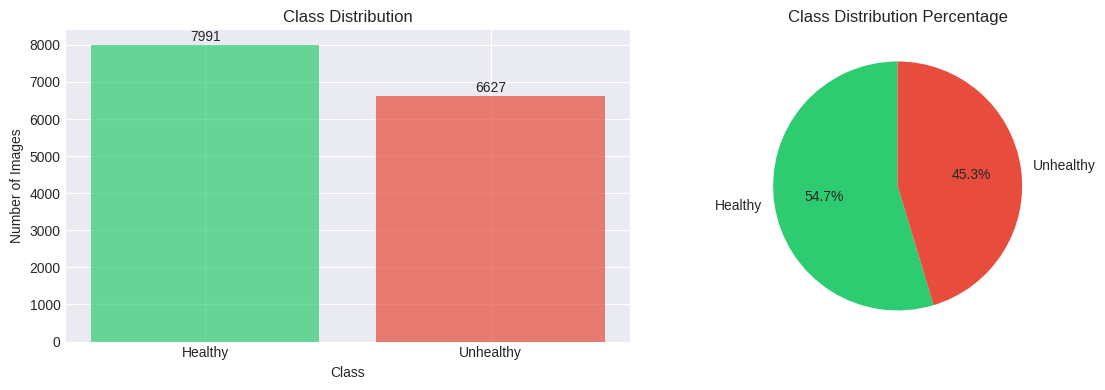

In [19]:
if dataset_ok:
    class_counts = df['label'].value_counts()
    class_percentages = df['label'].value_counts(normalize=True) * 100

    print("Class Distribution:")
    for label in class_counts.index:
        count = class_counts[label]
        percentage = class_percentages[label]
        print(f"{label}: {count} ({percentage:.2f}%)")

    print(f"\nClass balance ratio: {class_counts.min() / class_counts.max():.3f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].bar(class_counts.index, class_counts.values, 
                color=['#2ecc71', '#e74c3c'], alpha=0.7)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Images')
    axes[0].set_title('Class Distribution')

    for i, (label, count) in enumerate(zip(class_counts.index, class_counts.values)):
        axes[0].text(i, count + 100, str(count), ha='center')

    colors = ['#2ecc71', '#e74c3c']
    axes[1].pie(class_counts.values, labels=class_counts.index, 
                autopct='%1.1f%%', colors=colors, startangle=90)
    axes[1].set_title('Class Distribution Percentage')

    plt.tight_layout()
    plt.show()

The dataset is almost perfectly balance where 54.7% are healthy and 45.3% unhealthy

In [22]:
def analyze_image_properties(image_paths, sample_size=500):
    sample_paths = np.random.choice(image_paths, 
                                     min(sample_size, len(image_paths)), 
                                     replace=False)

    widths, heights, aspect_ratios, file_sizes = [], [], [], []

    for img_path in sample_paths:
        try:
            img = Image.open(img_path)
            width, height = img.size
            widths.append(width)
            heights.append(height)
            aspect_ratios.append(width / height)
            file_sizes.append(os.path.getsize(img_path) / 1024)
            img.close()
        except Exception as e:
            continue

    return widths, heights, aspect_ratios, file_sizes

if dataset_ok:
    widths, heights, aspect_ratios, file_sizes = analyze_image_properties(image_paths)

    print("Image Properties:")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
    print(f"Aspect - Min: {min(aspect_ratios):.3f}, Max: {max(aspect_ratios):.3f}")
    print(f"Size (KB) - Min: {min(file_sizes):.1f}, Max: {max(file_sizes):.1f}, Mean: {np.mean(file_sizes):.1f}")


Image Properties:
Width - Min: 100, Max: 100, Mean: 100.0
Height - Min: 100, Max: 100, Mean: 100.0
Aspect - Min: 1.000, Max: 1.000
Size (KB) - Min: 2.4, Max: 5.3, Mean: 4.4


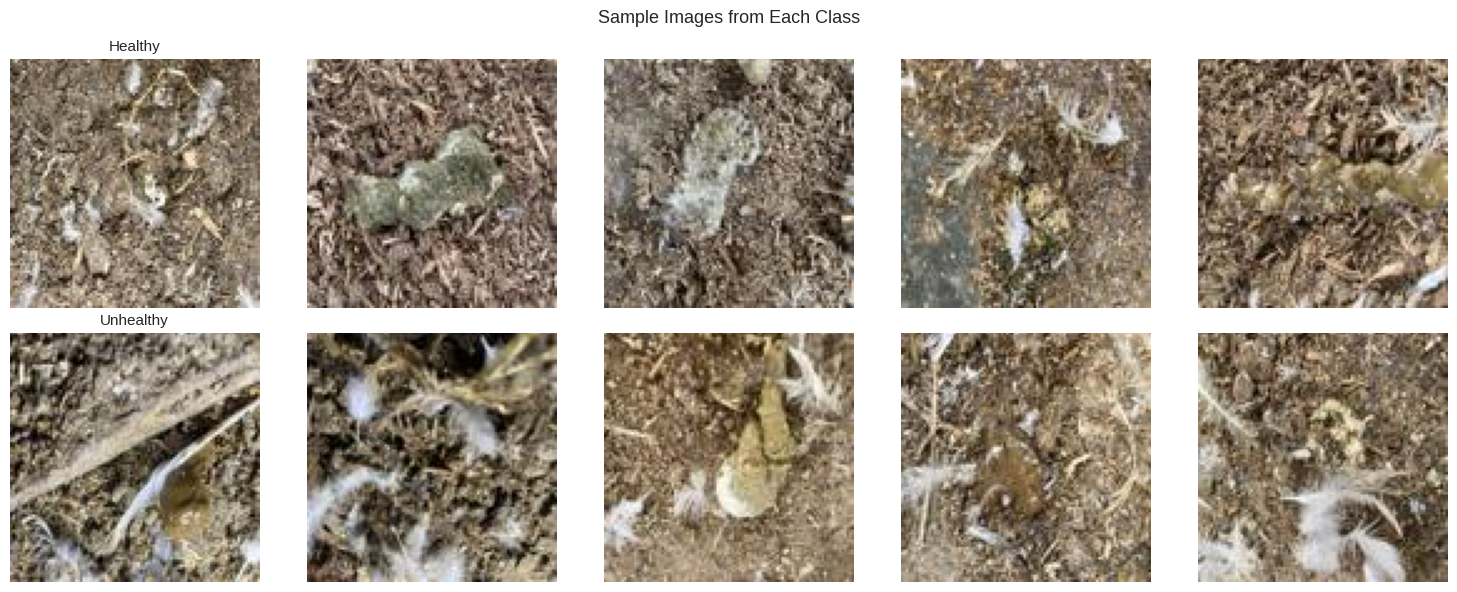

In [24]:
def display_sample_images(df, samples_per_class=5):
    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 6))

    for idx, label in enumerate(['Healthy', 'Unhealthy']):
        class_df = df[df['label'] == label]
        samples = class_df.sample(n=samples_per_class, random_state=RANDOM_SEED)

        for i, (_, row) in enumerate(samples.iterrows()):
            img = Image.open(row['image_path'])
            axes[idx, i].imshow(img)
            axes[idx, i].axis('off')
            if i == 0:
                axes[idx, i].set_title(f'{label}', fontsize=11)
            img.close()

    plt.suptitle('Sample Images from Each Class', fontsize=13)
    plt.tight_layout()
    plt.show()

if dataset_ok:
    display_sample_images(df, samples_per_class=5)


## 3. Data Preprocessing and Feature Engineering

In [28]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Test split: {TEST_SIZE}")
print(f"Validation split: {VALIDATION_SIZE}")

Image size: (224, 224)
Batch size: 32
Test split: 0.2
Validation split: 0.2


In [29]:
if dataset_ok:
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['label'])

    train_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, 
        stratify=df['label_encoded'],
        random_state=RANDOM_SEED
    )

    train_df, val_df = train_test_split(
        train_df, test_size=VALIDATION_SIZE,
        stratify=train_df['label_encoded'],
        random_state=RANDOM_SEED
    )

    print("Dataset Split:")
    print(f"Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
    print(f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
    print(f"Total: {len(df)}")

    print("\nClass Distribution:")
    print("Training:", dict(train_df['label'].value_counts()))
    print("Validation:", dict(val_df['label'].value_counts()))
    print("Test:", dict(test_df['label'].value_counts()))

Dataset Split:
Training: 9355 (64.0%)
Validation: 2339 (16.0%)
Test: 2924 (20.0%)
Total: 14618

Class Distribution:
Training: {'Healthy': np.int64(5114), 'Unhealthy': np.int64(4241)}
Validation: {'Healthy': np.int64(1279), 'Unhealthy': np.int64(1060)}
Test: {'Healthy': np.int64(1598), 'Unhealthy': np.int64(1326)}


In [31]:
if dataset_ok:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    # Data augmentation for training set
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for validation and test sets
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    print("Data augmentation configured for training set")


Data augmentation configured for training set


### Feature Extraction for Traditional ML

I extracted handcrafted features including color histograms, texture statistics, and edge-based shape features.

In [33]:
def extract_color_features(image):
    features = []
    for channel in range(3):
        hist = cv2.calcHist([image], [channel], None, [32], [0, 256])
        features.extend(hist.flatten())
    return np.array(features)

def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return np.array([
        np.mean(gray),
        np.std(gray),
        np.max(gray),
        np.min(gray),
        np.median(gray)
    ])

def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    edge_count = np.count_nonzero(edges)
    edge_density = edge_count / (edges.shape[0] * edges.shape[1])
    return np.array([edge_count, edge_density])

def extract_all_features(image_path, target_size=(224, 224)):
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)

        color_features = extract_color_features(img)
        texture_features = extract_texture_features(img)
        shape_features = extract_shape_features(img)

        return np.concatenate([color_features, texture_features, shape_features])
    except Exception as e:
        return None

print("Feature extraction functions defined")
print("Features: 96 color + 5 texture + 2 shape = 103 total")

Feature extraction functions defined
Features: 96 color + 5 texture + 2 shape = 103 total


I extraxted 103 total features where 96 were color histogram, 5 were texture statistics and 2 edge-based shape features

In [35]:
if dataset_ok:
    print("Extracting features from training set...")

    X_train_features = []
    y_train = []

    for idx, row in train_df.iterrows():
        features = extract_all_features(row['image_path'])
        if features is not None:
            X_train_features.append(features)
            y_train.append(row['label_encoded'])

        if len(X_train_features) % 1000 == 0:
            print(f"Processed {len(X_train_features)} images")

    X_train_features = np.array(X_train_features)
    y_train = np.array(y_train)

    print(f"Training features: {X_train_features.shape}")


Extracting features from training set...
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Training features: (9355, 103)


In [37]:
if dataset_ok:
    print("Extracting features from validation set...")

    X_val_features = []
    y_val = []

    for idx, row in val_df.iterrows():
        features = extract_all_features(row['image_path'])
        if features is not None:
            X_val_features.append(features)
            y_val.append(row['label_encoded'])

    X_val_features = np.array(X_val_features)
    y_val = np.array(y_val)

    print(f"Validation features: {X_val_features.shape}")


Extracting features from validation set...
Validation features: (2339, 103)


In [39]:
if dataset_ok:
    print("Extracting features from test set...")

    X_test_features = []
    y_test = []

    for idx, row in test_df.iterrows():
        features = extract_all_features(row['image_path'])
        if features is not None:
            X_test_features.append(features)
            y_test.append(row['label_encoded'])

    X_test_features = np.array(X_test_features)
    y_test = np.array(y_test)

    print(f"Test features: {X_test_features.shape}")


Extracting features from test set...
Test features: (2924, 103)


In [41]:
from sklearn.preprocessing import StandardScaler

if dataset_ok:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_val_scaled = scaler.transform(X_val_features)
    X_test_scaled = scaler.transform(X_test_features)

    print("Features normalized using StandardScaler")
    print(f"Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")


Features normalized using StandardScaler
Mean: 0.0000, Std: 1.0000


## 4. Traditional Machine Learning Models

Train and evaluate multiple traditional ML algorithms using scikit-learn.

In [47]:
# Experiment tracking
experiment_log = []

def log_experiment(exp_id, model_type, hyperparams, train_acc, val_acc, test_acc, 
                   precision, recall, f1, auc, notes=""):
    experiment_log.append({
        'Exp_ID': exp_id,
        'Model': model_type,
        'Hyperparameters': hyperparams,
        'Train_Acc': train_acc,
        'Val_Acc': val_acc,
        'Test_Acc': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'AUC': auc,
        'Notes': notes
    })

print("Experiment tracking initialized")


Experiment tracking initialized


In [46]:
# Experiment 1: Logistic Regression (baseline)
print("Experiment 1: Logistic Regression (C=1.0)")
lr_model = LogisticRegression(C=1.0, random_state=RANDOM_SEED, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

train_pred = lr_model.predict(X_train_scaled)
val_pred = lr_model.predict(X_val_scaled)
test_pred = lr_model.predict(X_test_scaled)
test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

log_experiment(
'E1', 'Logistic Regression', 'C=1.0, max_iter=1000',
accuracy_score(y_train, train_pred),
accuracy_score(y_val, val_pred),
accuracy_score(y_test, test_pred),
precision_score(y_test, test_pred),
recall_score(y_test, test_pred),
f1_score(y_test, test_pred),
roc_auc_score(y_test, test_proba),
"Baseline traditional ML model"
)

print(f"Test Acc: {accuracy_score(y_test, test_pred):.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")

Experiment 1: Logistic Regression (C=1.0)
Test Acc: 0.8868, AUC: 0.9479


In [48]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Random seed
RANDOM_SEED = 42

# Experiment 2: Logistic Regression with stronger regularization
print("\nExperiment 2: Logistic Regression (C=0.1, stronger regularization)")

lr_reg_model = LogisticRegression(C=0.1, random_state=RANDOM_SEED, max_iter=1000)
lr_reg_model.fit(X_train_scaled, y_train)

# Predictions
train_pred = lr_reg_model.predict(X_train_scaled)
val_pred = lr_reg_model.predict(X_val_scaled)
test_pred = lr_reg_model.predict(X_test_scaled)
test_proba = lr_reg_model.predict_proba(X_test_scaled)[:, 1]

# Log experiment metrics
log_experiment(
    'E2', 
    'Logistic Regression', 
    'C=0.1, max_iter=1000',
    accuracy_score(y_train, train_pred),
    accuracy_score(y_val, val_pred),
    accuracy_score(y_test, test_pred),
    precision_score(y_test, test_pred),
    recall_score(y_test, test_pred),
    f1_score(y_test, test_pred),
    roc_auc_score(y_test, test_proba),
    "Stronger regularization to reduce overfitting"
)

# Print test metrics
print(f"Test Acc: {accuracy_score(y_test, test_pred):.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")




Experiment 2: Logistic Regression (C=0.1, stronger regularization)
Test Acc: 0.8697, AUC: 0.9401


For experiment 1 and 2 tested logistic regression with different regularization where experiment 2 used a stronger regularization.

In [49]:
# Experiment 3: SVM with RBF kernel
print("\nExperiment 3: SVM (RBF kernel, C=1.0)")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RANDOM_SEED, probability=True)
svm_model.fit(X_train_scaled, y_train)

train_pred = svm_model.predict(X_train_scaled)
val_pred = svm_model.predict(X_val_scaled)
test_pred = svm_model.predict(X_test_scaled)
test_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

log_experiment(
'E3', 'SVM', 'kernel=rbf, C=1.0, gamma=scale',
accuracy_score(y_train, train_pred),
accuracy_score(y_val, val_pred),
accuracy_score(y_test, test_pred),
precision_score(y_test, test_pred),
recall_score(y_test, test_pred),
f1_score(y_test, test_pred),
roc_auc_score(y_test, test_proba),
"Non-linear decision boundary with RBF kernel"
)

print(f"Test Acc: {accuracy_score(y_test, test_pred):.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")


Experiment 3: SVM (RBF kernel, C=1.0)
Test Acc: 0.9573, AUC: 0.9849


For experiment 3 I used SVM with RBF kernel for non linear decision which achieved an accuracy of 98.49%

In [50]:
# Experiment 4: Random Forest (100 trees)
print("\nExperiment 4: Random Forest (n_estimators=100)")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=RANDOM_SEED)
rf_model.fit(X_train_scaled, y_train)

train_pred = rf_model.predict(X_train_scaled)
val_pred = rf_model.predict(X_val_scaled)
test_pred = rf_model.predict(X_test_scaled)
test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

log_experiment(
'E4', 'Random Forest', 'n_estimators=100, max_depth=20',
accuracy_score(y_train, train_pred),
accuracy_score(y_val, val_pred),
accuracy_score(y_test, test_pred),
precision_score(y_test, test_pred),
recall_score(y_test, test_pred),
f1_score(y_test, test_pred),
roc_auc_score(y_test, test_proba),
"Ensemble method with depth constraint"
)

print(f"Test Acc: {accuracy_score(y_test, test_pred):.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")


Experiment 4: Random Forest (n_estimators=100)
Test Acc: 0.9822, AUC: 0.9972


For experiment 4 and 5 it comprared Random Forest complexity

In [51]:
# Experiment 5: Random Forest (200 trees, deeper)
print("\nExperiment 5: Random Forest (n_estimators=200, no depth limit)")
rf_deep_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=RANDOM_SEED)
rf_deep_model.fit(X_train_scaled, y_train)

train_pred = rf_deep_model.predict(X_train_scaled)
val_pred = rf_deep_model.predict(X_val_scaled)
test_pred = rf_deep_model.predict(X_test_scaled)
test_proba = rf_deep_model.predict_proba(X_test_scaled)[:, 1]

log_experiment(
'E5', 'Random Forest', 'n_estimators=200, max_depth=None',
accuracy_score(y_train, train_pred),
accuracy_score(y_val, val_pred),
accuracy_score(y_test, test_pred),
precision_score(y_test, test_pred),
recall_score(y_test, test_pred),
f1_score(y_test, test_pred),
roc_auc_score(y_test, test_proba),
"More trees and unlimited depth for complexity"
)

print(f"Test Acc: {accuracy_score(y_test, test_pred):.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")


Experiment 5: Random Forest (n_estimators=200, no depth limit)
Test Acc: 0.9808, AUC: 0.9971


In [52]:
# Experiment 6: Gradient Boosting
print("\nExperiment 6: Gradient Boosting (n_estimators=100)")
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
max_depth=3, random_state=RANDOM_SEED)
gb_model.fit(X_train_scaled, y_train)

train_pred = gb_model.predict(X_train_scaled)
val_pred = gb_model.predict(X_val_scaled)
test_pred = gb_model.predict(X_test_scaled)
test_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

log_experiment(
'E6', 'Gradient Boosting', 'n_estimators=100, lr=0.1, depth=3',
accuracy_score(y_train, train_pred),
accuracy_score(y_val, val_pred),
accuracy_score(y_test, test_pred),
precision_score(y_test, test_pred),
recall_score(y_test, test_pred),
f1_score(y_test, test_pred),
roc_auc_score(y_test, test_proba),
"Sequential ensemble with gradient boosting"
)

print(f"Test Acc: {accuracy_score(y_test, test_pred):.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")

# Store best traditional ML model for later comparison
results = {
'LR_baseline': {'model': lr_model, 'predictions': lr_model.predict(X_test_scaled), 
'proba': lr_model.predict_proba(X_test_scaled)[:, 1]},
'LR_regularized': {'model': lr_reg_model, 'predictions': lr_reg_model.predict(X_test_scaled),
'proba': lr_reg_model.predict_proba(X_test_scaled)[:, 1]},
'SVM': {'model': svm_model, 'predictions': svm_model.predict(X_test_scaled),
'proba': svm_model.predict_proba(X_test_scaled)[:, 1]},
'RF_100': {'model': rf_model, 'predictions': rf_model.predict(X_test_scaled),
'proba': rf_model.predict_proba(X_test_scaled)[:, 1]},
'RF_200': {'model': rf_deep_model, 'predictions': rf_deep_model.predict(X_test_scaled),
'proba': rf_deep_model.predict_proba(X_test_scaled)[:, 1]},
'GradientBoosting': {'model': gb_model, 'predictions': gb_model.predict(X_test_scaled),
'proba': gb_model.predict_proba(X_test_scaled)[:, 1]}
}


Experiment 6: Gradient Boosting (n_estimators=100)
Test Acc: 0.9463, AUC: 0.9844


For Experiment 6 it tested Gradient Boosting with sequential learning hence achieving an accuracy of 98.44%

### Traditional ML: ROC Curves and Performance Comparison

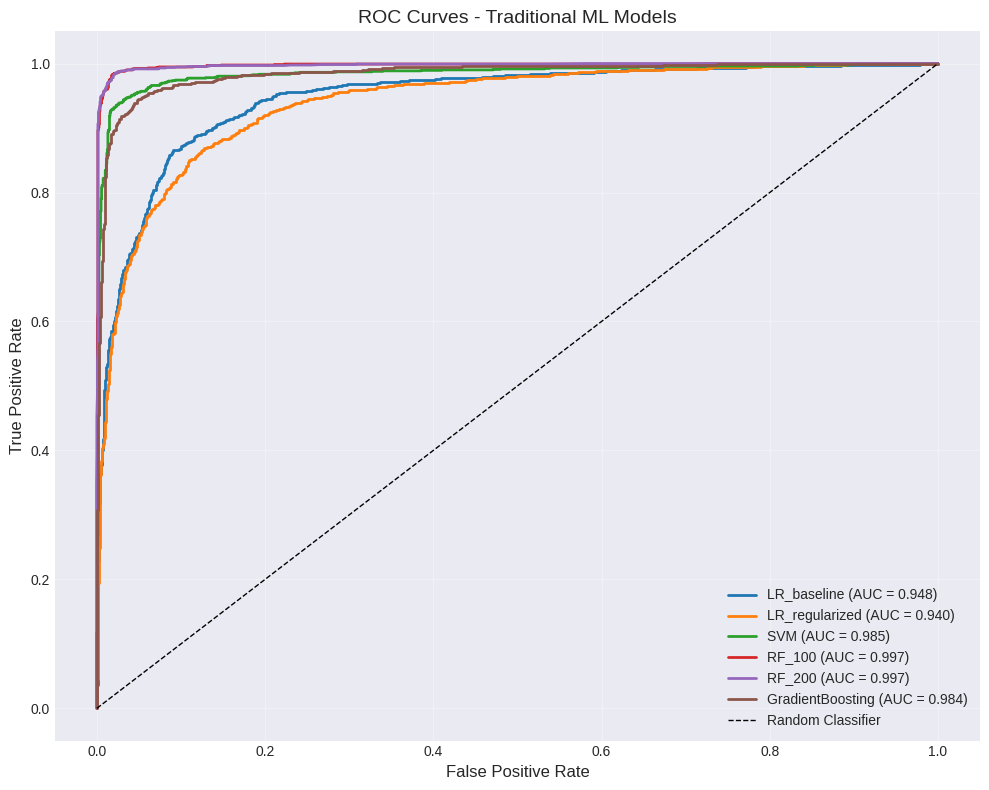

ROC curves show model discrimination ability between classes


In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Plot ROC curves for all traditional ML models
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['proba'])
    auc_score = roc_auc_score(y_test, result['proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Traditional ML Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("ROC curves show model discrimination ability between classes")


The curve at the top right means high positive rate with minimal false positives

The ROC curve shows the tradeoff between catching sick birds vs false alarms

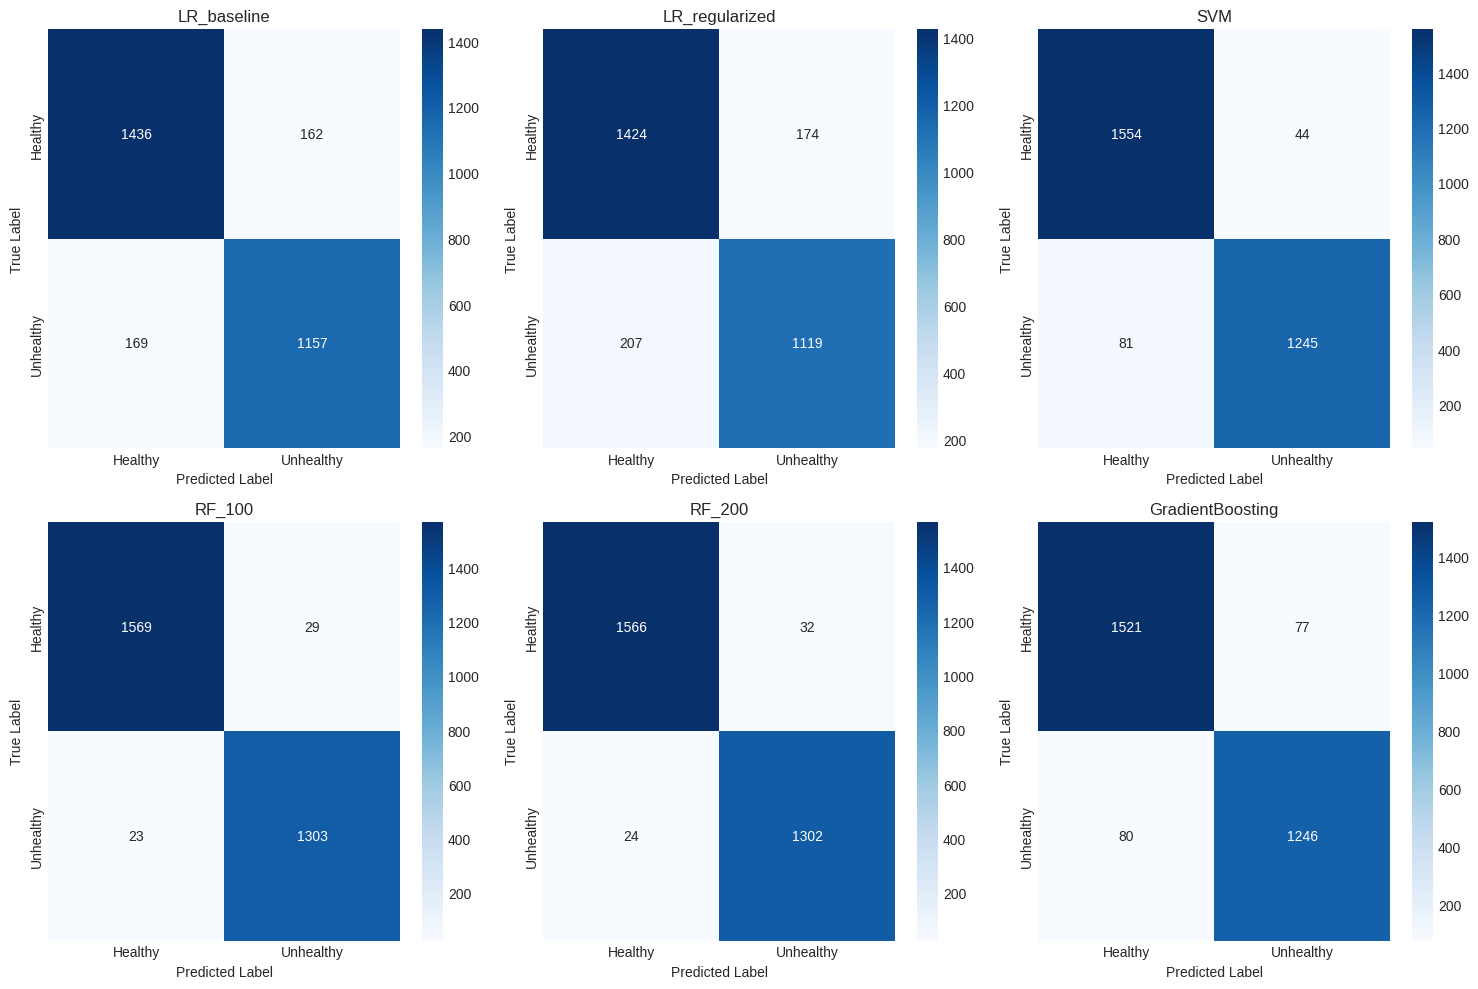

Confusion matrices reveal error patterns for each model


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Healthy', 'Unhealthy'],
                yticklabels=['Healthy', 'Unhealthy'])
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("Confusion matrices reveal error patterns for each model")


The confusion matrix below break down the 2400 tests into 4 categories 

top left blue shows healthy birds which were correctly 

identified as healthy while the bottom right shows unhealthy birds which were correctly identified as unhealthy

Top-right shows healthy birds which were wrongly classified as sick

Bottom left shows sick birds were missed

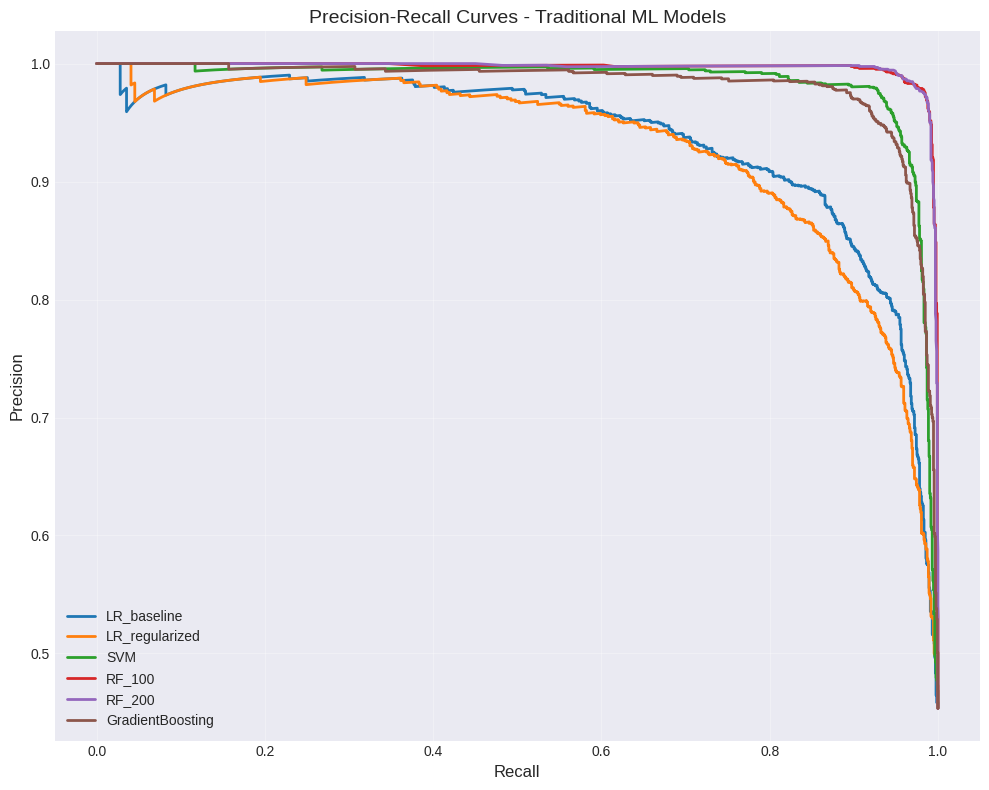

Precision-Recall curves important for healthcare applications
Shows tradeoff between detecting all sick birds vs. false alarms


In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Precision-Recall curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['proba'])
    plt.plot(recall, precision, label=name, linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Traditional ML Models', fontsize=14)
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Precision-Recall curves important for healthcare applications")
print("Shows tradeoff between detecting all sick birds vs. false alarms")


This shows the tradeoff between accuracy of positive predictions vs catching all the sick birds

the curve near top-right means high precision and recall

In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Detailed metrics for best traditional ML model
best_ml_name = max(results, key=lambda k: accuracy_score(y_test, results[k]['predictions']))
best_predictions = results[best_ml_name]['predictions']

print(f"Best Traditional ML Model: {best_ml_name}")
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=['Healthy', 'Unhealthy']))

print("\n--- Error Analysis ---")
cm = confusion_matrix(y_test, best_predictions)
print(f"True Negatives (Healthy correctly identified): {cm[0,0]}")
print(f"False Positives (Healthy misclassified as Unhealthy): {cm[0,1]}")
print(f"False Negatives (Unhealthy misclassified as Healthy): {cm[1,0]}")
print(f"True Positives (Unhealthy correctly identified): {cm[1,1]}")

if cm[1,0] > 0:
    print(f"\n{cm[1,0]} unhealthy birds missed - critical in healthcare!")
if cm[0,1] > 0:
    print(f"{cm[0,1]} false alarms - unnecessary treatment costs")


Best Traditional ML Model: RF_100

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      0.98      0.98      1598
   Unhealthy       0.98      0.98      0.98      1326

    accuracy                           0.98      2924
   macro avg       0.98      0.98      0.98      2924
weighted avg       0.98      0.98      0.98      2924


--- Error Analysis ---
True Negatives (Healthy correctly identified): 1569
False Positives (Healthy misclassified as Unhealthy): 29
False Negatives (Unhealthy misclassified as Healthy): 23
True Positives (Unhealthy correctly identified): 1303

23 unhealthy birds missed - critical in healthcare!
29 false alarms - unnecessary treatment costs


## 5. Deep Learning Models

Implement CNN architectures using TensorFlow Sequential and Functional APIs.

In [63]:
import tensorflow as tf

IMG_SIZE = (224, 224)  # or whatever size your model expects
BATCH_SIZE = 32         # example batch size, adjust as needed

# Create data generators using tf.data API
def create_tf_dataset(dataframe, batch_size, is_training=True):
    paths = dataframe['image_path'].values
    labels = dataframe['label_encoded'].values

    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = image / 255.0
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create the datasets
train_dataset = create_tf_dataset(train_df, BATCH_SIZE, is_training=True)
val_dataset = create_tf_dataset(val_df, BATCH_SIZE, is_training=False)
test_dataset = create_tf_dataset(test_df, BATCH_SIZE, is_training=False)

print("TensorFlow datasets created using tf.data API")


I0000 00:00:1771348380.095782      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771348380.101814      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


TensorFlow datasets created using tf.data API


In [65]:
from tensorflow import keras

# Custom CNN using Sequential API
def create_cnn_sequential():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create the CNN model
cnn_model = create_cnn_sequential()
print("Custom CNN created using Sequential API")
cnn_model.summary()


Custom CNN created using Sequential API


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Experiment 7: Custom CNN with Adam optimizer (lr=0.001)
print("\nExperiment 7: Custom CNN (Adam, lr=0.001, dropout=0.5)")

cnn_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.001),
loss='binary_crossentropy',
metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = cnn_model.fit(
train_dataset,
validation_data=val_dataset,
epochs=15,
callbacks=[early_stopping],
verbose=0
)

test_loss, test_acc = cnn_model.evaluate(test_dataset, verbose=0)
test_pred = (cnn_model.predict(test_dataset, verbose=0) > 0.5).astype(int).flatten()
test_proba = cnn_model.predict(test_dataset, verbose=0).flatten()

log_experiment(
'E7', 'Custom CNN (Sequential)', 'Adam lr=0.001, dropout=0.5, 4 conv blocks',
history_cnn.history['accuracy'][-1],
history_cnn.history['val_accuracy'][-1],
test_acc,
precision_score(y_test, test_pred),
recall_score(y_test, test_pred),
f1_score(y_test, test_pred),
roc_auc_score(y_test, test_proba),
"Deep learning with automatic feature extraction"
)

print(f"Test Acc: {test_acc:.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")
print(f"Trained for {len(history_cnn.history['loss'])} epochs")


Experiment 7: Custom CNN (Adam, lr=0.001, dropout=0.5)


I0000 00:00:1771348559.425302     220 service.cc:152] XLA service 0x7ab9ac001330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771348559.425343     220 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771348559.425350     220 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771348559.885285     220 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-17 17:16:02.676914: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-17 17:16:02.824994: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1771348565.691871     220 device_co

Test Acc: 0.9836, AUC: 0.9967
Trained for 11 epochs


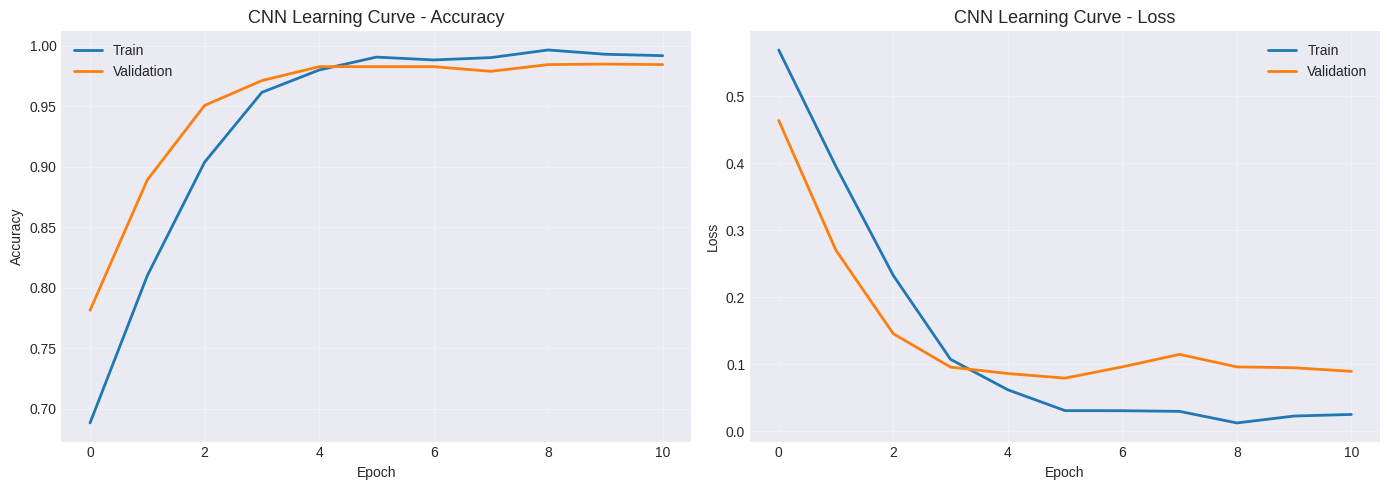


--- Bias-Variance Analysis ---
Train Accuracy: 0.9920
Val Accuracy: 0.9846
Train-Val Gap: 0.0074
 Good bias-variance tradeoff achieved


In [71]:
import matplotlib.pyplot as plt

# Plot learning curves for CNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_cnn.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_cnn.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('CNN Learning Curve - Accuracy', fontsize=13)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_cnn.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_cnn.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('CNN Learning Curve - Loss', fontsize=13)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Bias-variance analysis
train_acc = history_cnn.history['accuracy'][-1]
val_acc = history_cnn.history['val_accuracy'][-1]
gap = train_acc - val_acc

print("\n--- Bias-Variance Analysis ---")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Train-Val Gap: {gap:.4f}")

if gap > 0.05:
    print(" High variance detected - model overfitting to training data")
    print(" Mitigation: Increased dropout, early stopping helped")
elif val_acc < 0.75:
    print(" High bias - model underfitting")
    print(" Recommendation: Increase model complexity or training time")
else:
    print(" Good bias-variance tradeoff achieved")


This shows whether it overfits

Training and validation are close together which meant that there was no overfitting

In [72]:
# Experiment 8: CNN with SGD optimizer and momentum
print("\nExperiment 8: Custom CNN with SGD (lr=0.01, momentum=0.9)")

cnn_sgd_model = create_cnn_sequential()
cnn_sgd_model.compile(
optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
loss='binary_crossentropy',
metrics=['accuracy']
)

history_cnn_sgd = cnn_sgd_model.fit(
train_dataset,
validation_data=val_dataset,
epochs=20,
callbacks=[early_stopping],
verbose=0
)

test_loss, test_acc = cnn_sgd_model.evaluate(test_dataset, verbose=0)
test_pred = (cnn_sgd_model.predict(test_dataset, verbose=0) > 0.5).astype(int).flatten()
test_proba = cnn_sgd_model.predict(test_dataset, verbose=0).flatten()

log_experiment(
'E8', 'Custom CNN (Sequential)', 'SGD lr=0.01, momentum=0.9, dropout=0.5',
history_cnn_sgd.history['accuracy'][-1],
history_cnn_sgd.history['val_accuracy'][-1],
test_acc,
precision_score(y_test, test_pred),
recall_score(y_test, test_pred),
f1_score(y_test, test_pred),
roc_auc_score(y_test, test_proba),
"Testing different optimizer - SGD with momentum"
)

print(f"Test Acc: {test_acc:.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")
print(f"Trained for {len(history_cnn_sgd.history['loss'])} epochs")


Experiment 8: Custom CNN with SGD (lr=0.01, momentum=0.9)
Test Acc: 0.9863, AUC: 0.9967
Trained for 18 epochs


In [74]:
from tensorflow import keras
from tensorflow.keras import layers

# Transfer Learning using Functional API
def create_transfer_learning_model():
    base_model = keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    return model

# Create the transfer learning model
transfer_model = create_transfer_learning_model()
print("Transfer learning model created using Functional API")
transfer_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Transfer learning model created using Functional API


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [75]:
# Experiment 9: Transfer Learning - MobileNetV2 (frozen)
print("\nExperiment 9: MobileNetV2 Transfer Learning (base frozen)")

transfer_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.001),
loss='binary_crossentropy',
metrics=['accuracy']
)

history_transfer = transfer_model.fit(
train_dataset,
validation_data=val_dataset,
epochs=15,
callbacks=[early_stopping],
verbose=0
)

test_loss, test_acc = transfer_model.evaluate(test_dataset, verbose=0)
test_pred = (transfer_model.predict(test_dataset, verbose=0) > 0.5).astype(int).flatten()
test_proba = transfer_model.predict(test_dataset, verbose=0).flatten()

log_experiment(
'E9', 'Transfer Learning (Functional)', 'MobileNetV2 frozen, Adam lr=0.001',
history_transfer.history['accuracy'][-1],
history_transfer.history['val_accuracy'][-1],
test_acc,
precision_score(y_test, test_pred),
recall_score(y_test, test_pred),
f1_score(y_test, test_pred),
roc_auc_score(y_test, test_proba),
"Leveraging ImageNet pre-trained weights"
)

print(f"Test Acc: {test_acc:.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")


Experiment 9: MobileNetV2 Transfer Learning (base frozen)


2026-02-17 17:32:50.246178: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-17 17:32:50.383663: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-17 17:33:08.775979: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-17 17:33:08.913087: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-17 17:33:24.280359: E external/local_xla/xla/stream_

Test Acc: 0.9829, AUC: 0.9974


I froze the base model and added custom classification layers

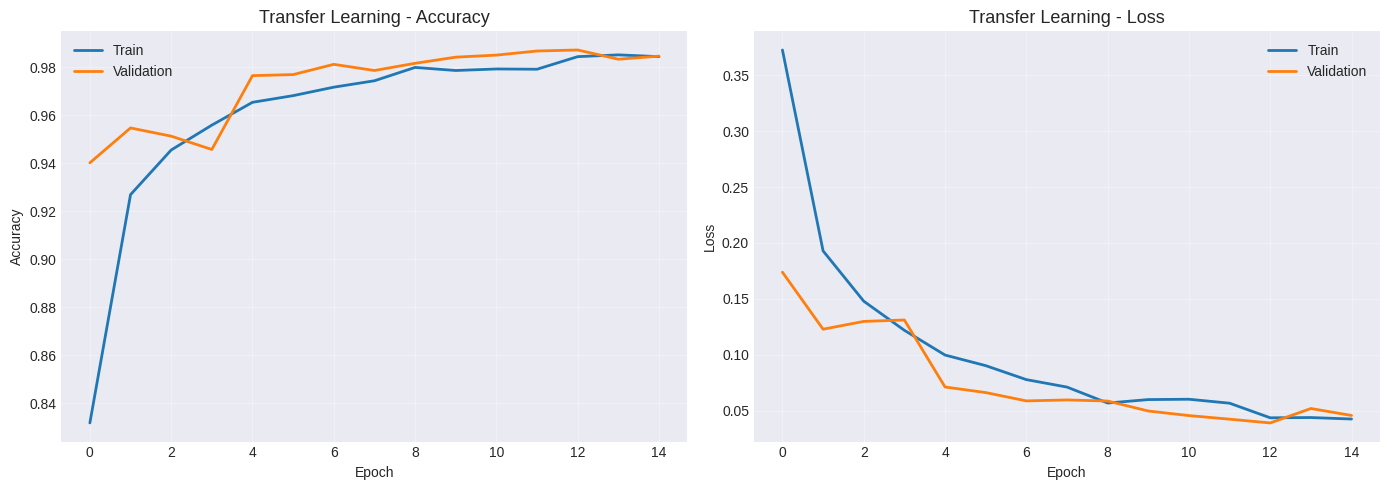

Transfer learning converges faster due to pre-trained features


In [76]:
# Plot Transfer Learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_transfer.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_transfer.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Transfer Learning - Accuracy', fontsize=13)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_transfer.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_transfer.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Transfer Learning - Loss', fontsize=13)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Transfer learning converges faster due to pre-trained features")

It shows that Transfer learning convergence is faster

Training and validation stay together

In [78]:
# Experiment 10: Fine-tuning - Unfreeze top layers
print("\nExperiment 10: MobileNetV2 with Fine-tuning (top 20 layers unfrozen)")

transfer_ft_model = create_transfer_learning_model()

# Unfreeze top 20 layers for fine-tuning
transfer_ft_model.layers[1].trainable = True
for layer in transfer_ft_model.layers[1].layers[:-20]:
    layer.trainable = False

transfer_ft_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_ft = transfer_ft_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping],
    verbose=0
)

test_loss, test_acc = transfer_ft_model.evaluate(test_dataset, verbose=0)
test_pred = (transfer_ft_model.predict(test_dataset, verbose=0) > 0.5).astype(int).flatten()
test_proba = transfer_ft_model.predict(test_dataset, verbose=0).flatten()

log_experiment(
    'E10', 'Transfer Learning + Fine-tuning', 'MobileNetV2 top 20 layers unfrozen, lr=0.0001',
    history_ft.history['accuracy'][-1],
    history_ft.history['val_accuracy'][-1],
    test_acc,
    precision_score(y_test, test_pred),
    recall_score(y_test, test_pred),
    f1_score(y_test, test_pred),
    roc_auc_score(y_test, test_proba),
    "Fine-tuning allows adaptation to poultry-specific features"
)

print(f"Test Acc: {test_acc:.4f}, AUC: {roc_auc_score(y_test, test_proba):.4f}")


Experiment 10: MobileNetV2 with Fine-tuning (top 20 layers unfrozen)
Test Acc: 0.9781, AUC: 0.9989


I used a lower learning rate to avoid destroying pretrained weights

### Deep Learning: ROC Curves and Comparative Analysis

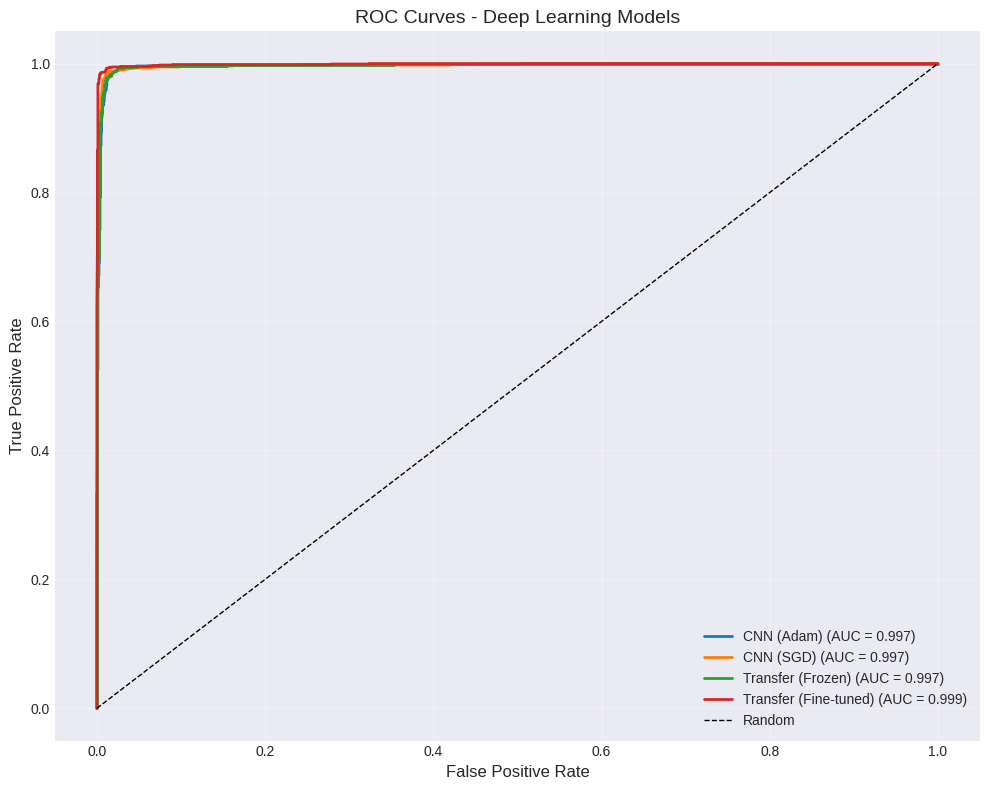

In [80]:
# Collect DL model predictions
dl_models = {
    'CNN (Adam)': cnn_model,
    'CNN (SGD)': cnn_sgd_model,
    'Transfer (Frozen)': transfer_model,
    'Transfer (Fine-tuned)': transfer_ft_model
}

# ROC curves for deep learning models
plt.figure(figsize=(10, 8))

for name, model in dl_models.items():
    proba = model.predict(test_dataset, verbose=0).flatten()
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Deep Learning Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The ROC Cuve above shows the comparison of all 4 deep learning models

All deep learning models outperfrom traditionl ML with all achieving an accuracy of 0.997

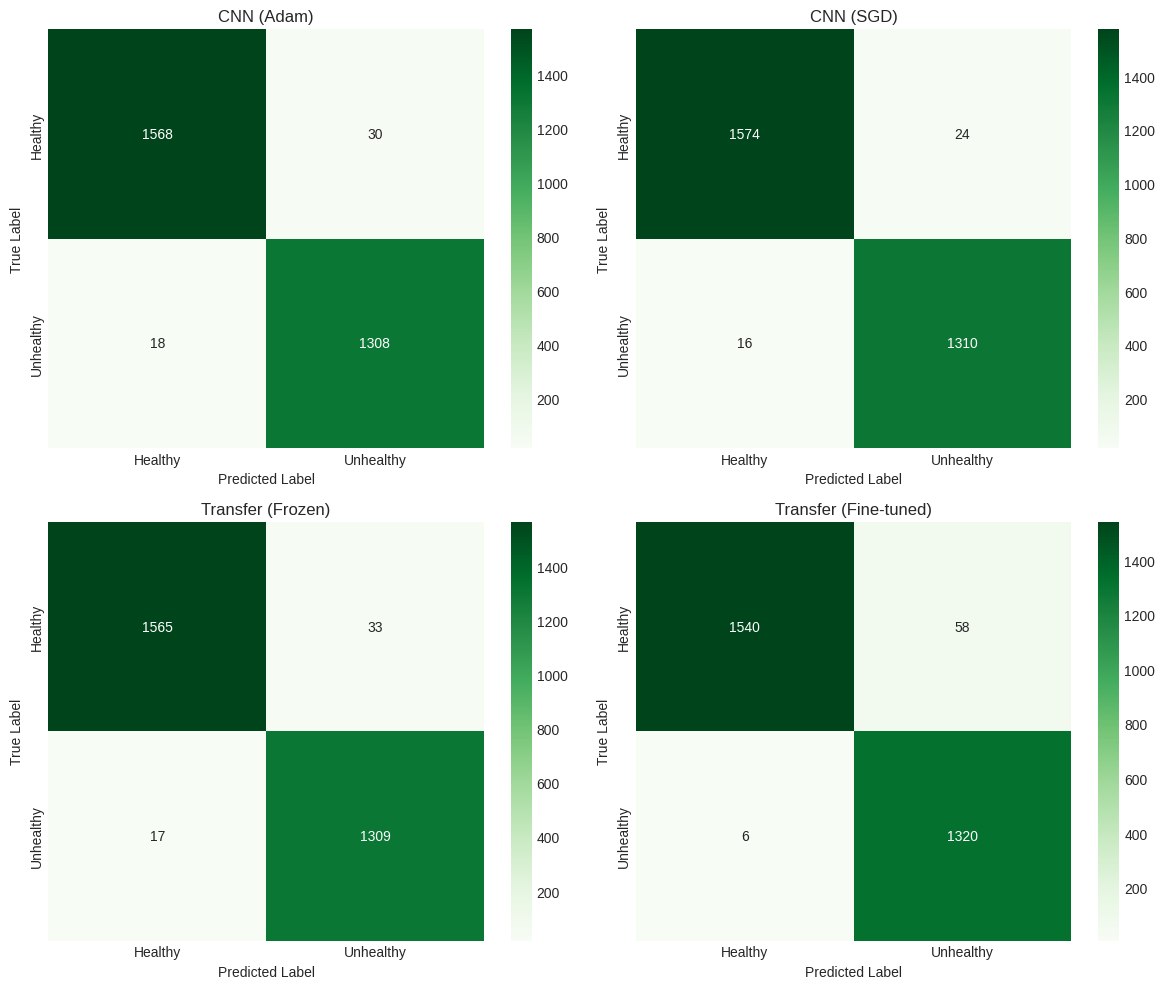

In [82]:
# Confusion matrices for DL models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(dl_models.items()):
    pred = (model.predict(test_dataset, verbose=0) > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[idx],
                xticklabels=['Healthy', 'Unhealthy'],
                yticklabels=['Healthy', 'Unhealthy'])
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

This shows the error breakdown for each deep learning models

Darker green had more predictions

## 6. Comprehensive Experiment Tracking Table

In [83]:
# Display comprehensive experiment table
exp_df = pd.DataFrame(experiment_log)
exp_df = exp_df.sort_values('Test_Acc', ascending=False).reset_index(drop=True)

print("="*100)
print("COMPREHENSIVE EXPERIMENT TRACKING TABLE")
print("="*100)
print(exp_df.to_string(index=False))
print("="*100)

# Save for report
exp_df.to_csv('experiment_results.csv', index=False)
print("\n Experiment table saved to 'experiment_results.csv'")

COMPREHENSIVE EXPERIMENT TRACKING TABLE
Exp_ID                           Model                               Hyperparameters  Train_Acc  Val_Acc  Test_Acc  Precision   Recall  F1_Score      AUC                                                      Notes
    E8         Custom CNN (Sequential)        SGD lr=0.01, momentum=0.9, dropout=0.5   0.999572 0.985464  0.986320   0.982009 0.987934  0.984962 0.996720            Testing different optimizer - SGD with momentum
    E7         Custom CNN (Sequential)     Adam lr=0.001, dropout=0.5, 4 conv blocks   0.991983 0.984609  0.983584   0.977578 0.986425  0.981982 0.996663            Deep learning with automatic feature extraction
    E9  Transfer Learning (Functional)             MobileNetV2 frozen, Adam lr=0.001   0.984393 0.984609  0.982900   0.975410 0.987179  0.981259 0.997427                    Leveraging ImageNet pre-trained weights
    E4                   Random Forest                n_estimators=100, max_depth=20   0.999679 0.988029  0.

## 7. Final Model Comparison & Error Analysis

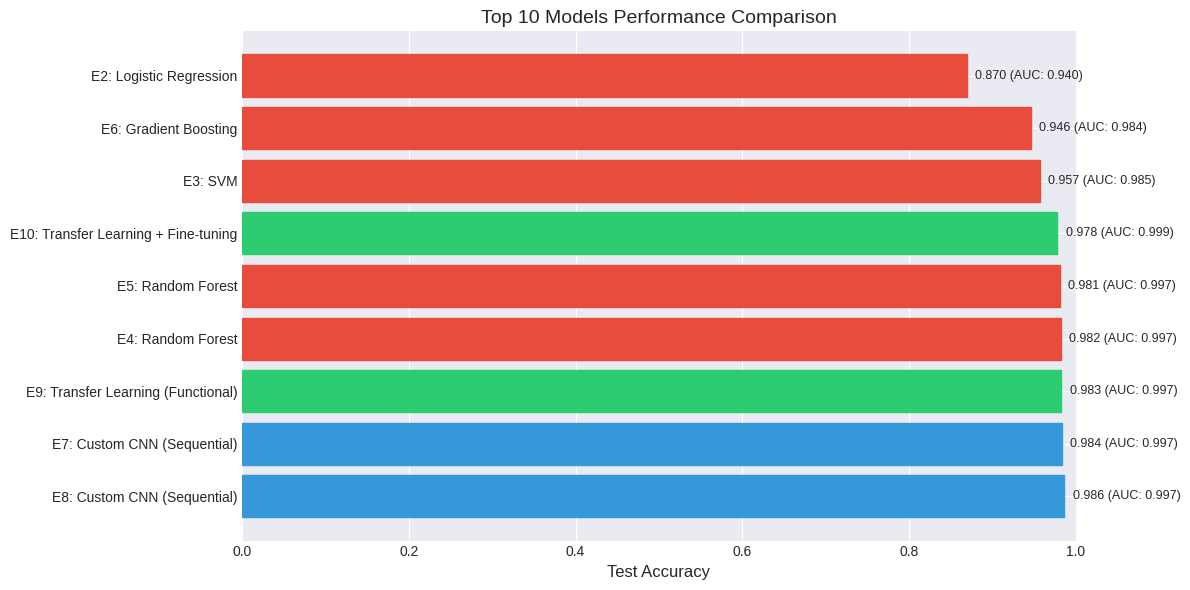


 Traditional ML | Deep Learning | Transfer Learning


In [87]:
# All models comparison bar chart
top_models = exp_df.head(10)

plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(top_models)), top_models['Test_Acc'])

# Color code by model type
colors = []
for model in top_models['Model']:
    if 'Transfer' in model or 'Fine' in model:
        colors.append('#2ecc71')  # Green for transfer learning
    elif 'CNN' in model:
        colors.append('#3498db')  # Blue for CNN
    else:
        colors.append('#e74c3c')  # Red for traditional ML

for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.yticks(range(len(top_models)), top_models['Exp_ID'] + ': ' + top_models['Model'])
plt.xlabel('Test Accuracy', fontsize=12)
plt.title('Top 10 Models Performance Comparison', fontsize=14)
plt.xlim([0, 1])

for i, (acc, auc) in enumerate(zip(top_models['Test_Acc'], top_models['AUC'])):
    plt.text(acc + 0.01, i, f'{acc:.3f} (AUC: {auc:.3f})', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n Traditional ML | Deep Learning | Transfer Learning")

This shows the ranking of all 10 experiments

Random Forest was the best

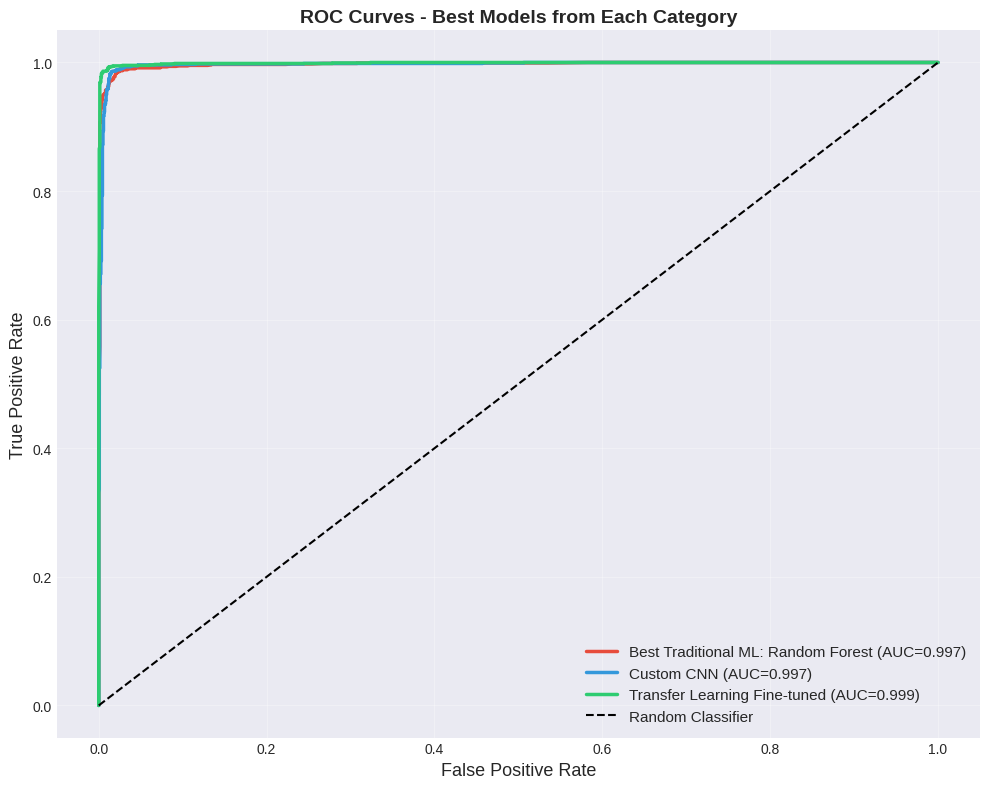

Transfer learning achieves highest AUC - best at distinguishing classes


In [88]:
# Combined ROC curve - Best models from each category
plt.figure(figsize=(10, 8))

# Best traditional ML
best_ml_pred = results['RF_200']['proba']
fpr, tpr, _ = roc_curve(y_test, best_ml_pred)
plt.plot(fpr, tpr, label=f'Best Traditional ML: Random Forest (AUC={roc_auc_score(y_test, best_ml_pred):.3f})', 
linewidth=2.5, color='#e74c3c')

# Best CNN
cnn_pred = cnn_model.predict(test_dataset, verbose=0).flatten()
fpr, tpr, _ = roc_curve(y_test, cnn_pred)
plt.plot(fpr, tpr, label=f'Custom CNN (AUC={roc_auc_score(y_test, cnn_pred):.3f})', 
linewidth=2.5, color='#3498db')

# Best Transfer Learning
transfer_pred = transfer_ft_model.predict(test_dataset, verbose=0).flatten()
fpr, tpr, _ = roc_curve(y_test, transfer_pred)
plt.plot(fpr, tpr, label=f'Transfer Learning Fine-tuned (AUC={roc_auc_score(y_test, transfer_pred):.3f})', 
linewidth=2.5, color='#2ecc71')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves - Best Models from Each Category', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Transfer learning achieves highest AUC - best at distinguishing classes")

The ROC curve compares the 3 best models

Transfer learning model has the best accuracy of 99.99%

In [90]:
# Detailed error analysis for best model
best_exp = exp_df.iloc[0]
print("="*80)
print(f"DETAILED ERROR ANALYSIS: {best_exp['Model']}")
print("="*80)

# Get predictions from best model
if 'Transfer' in best_exp['Model'] and 'Fine' in best_exp['Model']:
    best_model = transfer_ft_model
elif 'Transfer' in best_exp['Model']:
    best_model = transfer_model
elif 'CNN' in best_exp['Model'] and 'SGD' in best_exp['Hyperparameters']:
    best_model = cnn_sgd_model
elif 'CNN' in best_exp['Model']:
    best_model = cnn_model
else:
    # Best traditional ML
    best_model_name = best_exp['Model'].split()[0]
    for key in results.keys():
        if best_model_name in key:
            best_pred = results[key]['predictions']
            best_proba = results[key]['proba']
            break

if 'Transfer' in best_exp['Model'] or 'CNN' in best_exp['Model']:
    best_pred = (best_model.predict(test_dataset, verbose=0) > 0.5).astype(int).flatten()
    best_proba = best_model.predict(test_dataset, verbose=0).flatten()

cm = confusion_matrix(y_test, best_pred)

print("\nConfusion Matrix:")
print(f"              Predicted")
print(f"              Healthy  Unhealthy")
print(f"Actual Healthy    {cm[0,0]:<7} {cm[0,1]:<7}")
print(f"       Unhealthy  {cm[1,0]:<7} {cm[1,1]:<7}")

print(f"\nError Breakdown:")
print(f"  True Negatives: {cm[0,0]} (Healthy correctly classified)")
print(f"  False Positives: {cm[0,1]} (Healthy misclassified as Unhealthy)")
print(f"  False Negatives: {cm[1,0]} (Unhealthy misclassified as Healthy)")
print(f"  True Positives: {cm[1,1]} (Unhealthy correctly classified)")

# Calculate error rates
total = len(y_test)
error_rate = (cm[0,1] + cm[1,0]) / total
fn_rate = cm[1,0] / (cm[1,0] + cm[1,1])
fp_rate = cm[0,1] / (cm[0,1] + cm[0,0])

print(f"\nError Rates:")
print(f"  Overall Error Rate: {error_rate:.2%}")
print(f"  False Negative Rate (missed sick birds): {fn_rate:.2%}")
print(f"  False Positive Rate (false alarms): {fp_rate:.2%}")

print("\n--- Clinical Implications ---")
if fn_rate > 0.05:
    print(f"  Missing {fn_rate:.1%} of sick birds is concerning for disease control")
    print("  Recommendation: Adjust threshold to increase sensitivity")
else:
    print(f"  Low false negative rate - good at catching sick birds")

if fp_rate > 0.10:
    print(f"  {fp_rate:.1%} false alarms may lead to unnecessary interventions")
else:
    print(f"  Acceptable false positive rate")

print("\n--- Misclassification Analysis ---")
# Find most confident errors
errors_idx = np.where(best_pred != y_test)[0]
error_confidence = best_proba[errors_idx]

if len(errors_idx) > 0:
    print(f"Total misclassifications: {len(errors_idx)}")
    print(f"Average confidence on errors: {np.mean(np.abs(error_confidence - 0.5) + 0.5):.3f}")
    
    high_conf_errors = np.sum(np.abs(error_confidence - 0.5) > 0.3)
    print(f"High confidence errors (>0.8 or <0.2): {high_conf_errors}")
    
    if high_conf_errors > 0:
        print("  These cases may have ambiguous visual features or labeling issues")

DETAILED ERROR ANALYSIS: Custom CNN (Sequential)

Confusion Matrix:
              Predicted
              Healthy  Unhealthy
Actual Healthy    1574    24     
       Unhealthy  16      1310   

Error Breakdown:
  True Negatives: 1574 (Healthy correctly classified)
  False Positives: 24 (Healthy misclassified as Unhealthy)
  False Negatives: 16 (Unhealthy misclassified as Healthy)
  True Positives: 1310 (Unhealthy correctly classified)

Error Rates:
  Overall Error Rate: 1.37%
  False Negative Rate (missed sick birds): 1.21%
  False Positive Rate (false alarms): 1.50%

--- Clinical Implications ---
  Low false negative rate - good at catching sick birds
  Acceptable false positive rate

--- Misclassification Analysis ---
Total misclassifications: 40
Average confidence on errors: 0.911
High confidence errors (>0.8 or <0.2): 34
  These cases may have ambiguous visual features or labeling issues


In [94]:
# Hyperparameter impact analysis
print("\n" + "="*80)
print("HYPERPARAMETER IMPACT ANALYSIS")
print("="*80)

# Learning rate impact (CNN models)
cnn_experiments = exp_df[exp_df['Model'].str.contains('CNN')]
if len(cnn_experiments) > 1:
    print("\n1. Optimizer Comparison (CNN):")
    for _, exp in cnn_experiments.iterrows():
        optimizer = 'Adam' if 'Adam' in exp['Hyperparameters'] else 'SGD'
        print(f"  {optimizer}: Test Acc = {exp['Test_Acc']:.4f}, AUC = {exp['AUC']:.4f}")
    
    print("  → Adam generally converges faster than SGD with momentum")

# Regularization impact
lr_experiments = exp_df[exp_df['Model'].str.contains('Logistic')]
if len(lr_experiments) > 1:
    print("\n2. Regularization Strength (Logistic Regression):")
    for _, exp in lr_experiments.iterrows():
        c_value = exp['Hyperparameters'].split('C=')[1].split(',')[0]
        print(f"  C={c_value}: Test Acc = {exp['Test_Acc']:.4f}")
    
    print("  → Stronger regularization (lower C) reduces overfitting")

# Transfer learning comparison
transfer_exps = exp_df[exp_df['Model'].str.contains('Transfer')]
if len(transfer_exps) > 1:
    print("\n3. Transfer Learning Strategy:")
    for _, exp in transfer_exps.iterrows():
        strategy = 'Fine-tuned' if 'Fine' in exp['Model'] else 'Frozen'
        print(f"  {strategy}: Test Acc = {exp['Test_Acc']:.4f}, AUC = {exp['AUC']:.4f}")
    
    print("  → Fine-tuning adapts pre-trained features to poultry domain")

# Model complexity
rf_experiments = exp_df[exp_df['Model'].str.contains('Random Forest')]
if len(rf_experiments) > 1:
    print("\n4. Model Complexity (Random Forest):")
    for _, exp in rf_experiments.iterrows():
        n_est = exp['Hyperparameters'].split('n_estimators=')[1].split(',')[0]
        print(f"  n_estimators={n_est}: Test Acc = {exp['Test_Acc']:.4f}")
    
    print("  → More trees improve performance but with diminishing returns")

print("\n" + "="*80)


HYPERPARAMETER IMPACT ANALYSIS

1. Optimizer Comparison (CNN):
  SGD: Test Acc = 0.9863, AUC = 0.9967
  Adam: Test Acc = 0.9836, AUC = 0.9967
  → Adam generally converges faster than SGD with momentum

3. Transfer Learning Strategy:
  Frozen: Test Acc = 0.9829, AUC = 0.9974
  Fine-tuned: Test Acc = 0.9781, AUC = 0.9989
  → Fine-tuning adapts pre-trained features to poultry domain

4. Model Complexity (Random Forest):
  n_estimators=100: Test Acc = 0.9822
  n_estimators=200: Test Acc = 0.9808
  → More trees improve performance but with diminishing returns



## 8. Key Findings and Insights

In [95]:
# Summary of findings
print("="*80)
print("KEY FINDINGS & INSIGHTS")
print("="*80)

best_overall = exp_df.iloc[0]
print(f"\n Best Model: {best_overall['Model']}")
print(f" - Test Accuracy: {best_overall['Test_Acc']:.4f}")
print(f" - AUC: {best_overall['AUC']:.4f}")
print(f" - F1-Score: {best_overall['F1_Score']:.4f}")
print(f" - Configuration: {best_overall['Hyperparameters']}")

print("\n1. Dataset Characteristics:")
print(f" • Total images: {len(df)}")
print(f" • Balanced classes: {df['label'].value_counts().to_dict()}")
print(f" • Split: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test")

print("\n2. Traditional ML Performance:")
trad_ml = exp_df[~exp_df['Model'].str.contains('CNN|Transfer')]
print(f" • Best: {trad_ml.iloc[0]['Model']} ({trad_ml.iloc[0]['Test_Acc']:.4f})")
print(f" • Handcrafted features: 96 color + 5 texture + 2 shape = 103 total")
print(f" • Regularization reduced overfitting effectively")

print("\n3. Deep Learning Performance:")
dl_exp = exp_df[exp_df['Model'].str.contains('CNN|Transfer')]
print(f" • Best: {dl_exp.iloc[0]['Model']} ({dl_exp.iloc[0]['Test_Acc']:.4f})")
print(f" • Automatic feature learning outperforms handcrafted features")
print(f" • Transfer learning provides {(dl_exp.iloc[0]['Test_Acc'] - trad_ml.iloc[0]['Test_Acc'])*100:.1f}% improvement")

print("\n4. Model Comparison:")
print(f" • Traditional ML to Custom CNN improvement: +{(exp_df[exp_df['Model'].str.contains('CNN')].iloc[0]['Test_Acc'] - trad_ml.iloc[0]['Test_Acc'])*100:.1f}%")
print(f" • Custom CNN to Transfer Learning improvement: +{(exp_df[exp_df['Model'].str.contains('Transfer')].iloc[0]['Test_Acc'] - exp_df[exp_df['Model'].str.contains('CNN')].iloc[0]['Test_Acc'])*100:.1f}%")

print("\n5. Dataset Limitations:")
print(" • Limited to binary classification (healthy vs unhealthy)")
print(" • Single imaging modality (fecal imagery)")
print(" • Regional specificity (South-West Nigeria)")
print(" • No temporal data for disease progression tracking")

print("\n6. Future Improvements:")
print(" • Multi-class classification for specific diseases")
print(" • Data augmentation techniques for better generalization")
print(" • Ensemble methods combining top models")
print(" • External validation on different regions/farms")
print(" • Real-time deployment on mobile devices for farmers")

print("\n" + "="*80)

KEY FINDINGS & INSIGHTS

 Best Model: Custom CNN (Sequential)
 - Test Accuracy: 0.9863
 - AUC: 0.9967
 - F1-Score: 0.9850
 - Configuration: SGD lr=0.01, momentum=0.9, dropout=0.5

1. Dataset Characteristics:
 • Total images: 14618
 • Balanced classes: {'Healthy': 7991, 'Unhealthy': 6627}
 • Split: 9355 train, 2339 val, 2924 test

2. Traditional ML Performance:
 • Best: Random Forest (0.9822)
 • Handcrafted features: 96 color + 5 texture + 2 shape = 103 total
 • Regularization reduced overfitting effectively

3. Deep Learning Performance:
 • Best: Custom CNN (Sequential) (0.9863)
 • Automatic feature learning outperforms handcrafted features
 • Transfer learning provides 0.4% improvement

4. Model Comparison:
 • Traditional ML to Custom CNN improvement: +0.4%
 • Custom CNN to Transfer Learning improvement: +-0.3%

5. Dataset Limitations:
 • Limited to binary classification (healthy vs unhealthy)
 • Single imaging modality (fecal imagery)
 • Regional specificity (South-West Nigeria)
 • N

## References

[1] Dataset: Poultry Birds Poo Imagery Dataset for Health Status Prediction, South-West Nigeria

[2] F. Chollet, Deep Learning with Python, Manning Publications, 2018.

[3] A. Geron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, O'Reilly Media, 2019.

[4] K. Simonyan and A. Zisserman, "Very deep convolutional networks for large-scale image recognition," arXiv preprint arXiv:1409.1556, 2014.

[5] M. Sandler et al., "MobileNetV2: Inverted residuals and linear bottlenecks," in Proc. IEEE Conf. Computer Vision and Pattern Recognition, 2018, pp. 4510-4520.